Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/nin-cifar10.ipynb)

## Code Modules, Classes, & Functions

In [23]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
import sklearn.preprocessing as skp
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [24]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [25]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i])\
                      .reshape(img_size,img_size,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(train_loader,classes,num_examples):
    dataiter=iter(train_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:num_examples]))
    print('^'.join('%9s'%classes[labels[j]] 
                   for j in range(num_examples)),end='^')

In [26]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [27]:
img_size=32
random_seed=1; batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5); tr1=(.48,.48,.48)
train_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,
                     download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Files already downloaded and verified


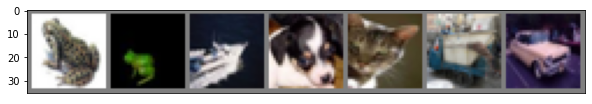

     frog^     frog^     ship^      dog^      cat^    truck^      car^

In [28]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [29]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
print(x.mean(),x.std())
x=skp.MinMaxScaler((.05,.9))\
.fit_transform(x.reshape(-1,img_size*img_size*3))
x=x.reshape(-1,3,img_size,img_size)
print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

['backgrounds', 'images', 'labels']
0.5900519 0.1395963
0.5122161 0.13431434


In [30]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

Image dimensions: torch.Size([128, 3, 32, 32])
Label dimensions: torch.Size([128])


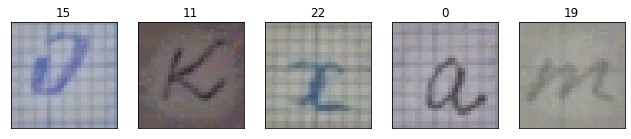

In [31]:
display_examples(valid_loader2,img_size)

## NNinNN

In [32]:
def convrelu(x,y,k,s,p):
    return tnn.Sequential(
        tnn.Conv2d(x,y,kernel_size=k,
                   stride=s,padding=p),\
        tnn.ReLU(inplace=True))
class NNinNN(tnn.Module):
    def __init__(self,num_classes):
        super(NNinNN,self).__init__()
        self.num_classes=num_classes
        self.classifier=tnn.Sequential(
            convrelu(3,192,5,1,2),
            convrelu(192,160,1,1,0),
            convrelu(160,96,1,1,0),
            tnn.MaxPool2d(kernel_size=3,
                          stride=2,padding=1),
            tnn.Dropout(.5),
            convrelu(96,192,5,1,2),
            convrelu(192,192,1,1,0),
            convrelu(192,192,1,1,0),
            tnn.AvgPool2d(kernel_size=3,
                          stride=2,padding=1),
            tnn.Dropout(.5),
            convrelu(192,192,3,1,1),
            convrelu(192,192,1,1,0),
            convrelu(192,self.num_classes,1,1,0),
            tnn.AvgPool2d(kernel_size=8,
                          stride=1,padding=0))
    def forward(self,x):
        x=self.classifier(x)
        logits=x.view(x.size(0),self.num_classes)
        probs=torch.softmax(logits,dim=1)
        return logits,probs

## Training

In [33]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost)) 
        model.eval()        
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [34]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.0001
model=NNinNN(num_classes); model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [35]:
%train_run 200

Epoch: 001/200 | Batch 000/343 | Cost: 2.3027
Epoch: 001/200 | Batch 100/343 | Cost: 2.1858
Epoch: 001/200 | Batch 200/343 | Cost: 2.0433
Epoch: 001/200 | Batch 300/343 | Cost: 1.9166
Epoch: 001/200 train acc: 29.07% valid acc: 29.75%
Epoch: 002/200 | Batch 000/343 | Cost: 1.8987
Epoch: 002/200 | Batch 100/343 | Cost: 1.7657
Epoch: 002/200 | Batch 200/343 | Cost: 1.7789
Epoch: 002/200 | Batch 300/343 | Cost: 1.8628
Epoch: 002/200 train acc: 32.97% valid acc: 33.18%
Epoch: 003/200 | Batch 000/343 | Cost: 1.8483
Epoch: 003/200 | Batch 100/343 | Cost: 1.8512
Epoch: 003/200 | Batch 200/343 | Cost: 1.7490
Epoch: 003/200 | Batch 300/343 | Cost: 1.6253
Epoch: 003/200 train acc: 36.44% valid acc: 36.62%
Epoch: 004/200 | Batch 000/343 | Cost: 1.7715
Epoch: 004/200 | Batch 100/343 | Cost: 1.8994
Epoch: 004/200 | Batch 200/343 | Cost: 1.6576
Epoch: 004/200 | Batch 300/343 | Cost: 1.7608
Epoch: 004/200 train acc: 38.57% valid acc: 39.22%
Epoch: 005/200 | Batch 000/343 | Cost: 1.6924
Epoch: 005/200

In [36]:
%print_acc 1

Train accuracy: 83.3250%
Valid accuracy: 72.1167%
Test accuracy: 71.8200%


In [37]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer2.zero_grad(); cost.backward()
            optimizer2.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))

In [38]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.0001
model=NNinNN(num_classes)
model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

In [39]:
%train_run2 200

Epoch: 001/200 | Batch 000/088 | Cost: 3.4944
Epoch: 001/200 | Batch 050/088 | Cost: 3.5004
Epoch: 001/200 train acc: 3.35% valid acc: 3.10%
Epoch: 002/200 | Batch 000/088 | Cost: 3.4973
Epoch: 002/200 | Batch 050/088 | Cost: 3.4899
Epoch: 002/200 train acc: 5.07% valid acc: 4.86%
Epoch: 003/200 | Batch 000/088 | Cost: 3.4744
Epoch: 003/200 | Batch 050/088 | Cost: 3.4640
Epoch: 003/200 train acc: 5.29% valid acc: 5.99%
Epoch: 004/200 | Batch 000/088 | Cost: 3.4635
Epoch: 004/200 | Batch 050/088 | Cost: 3.4365
Epoch: 004/200 train acc: 5.20% valid acc: 5.29%
Epoch: 005/200 | Batch 000/088 | Cost: 3.4478
Epoch: 005/200 | Batch 050/088 | Cost: 3.4547
Epoch: 005/200 train acc: 5.81% valid acc: 6.69%
Epoch: 006/200 | Batch 000/088 | Cost: 3.3849
Epoch: 006/200 | Batch 050/088 | Cost: 3.4473
Epoch: 006/200 train acc: 6.36% valid acc: 7.33%
Epoch: 007/200 | Batch 000/088 | Cost: 3.4292
Epoch: 007/200 | Batch 050/088 | Cost: 3.3883
Epoch: 007/200 train acc: 6.03% valid acc: 6.27%
Epoch: 008/20

In [40]:
%print_acc 2

Train accuracy: 51.7001%
Valid accuracy: 46.9345%
Test accuracy: 48.3439%
